In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import string
import re
import codecs
import json
#%matplotlib inline
#pd.set_option('display.max_colwidth', 100)

import hdbscan
import nltk
import numpy as np
import pandas as pd
import random
import re
import spacy
import textacy
import csv
import sklearn

from gmplot import gmplot
from mapsplotlib import mapsplot as mplt
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag_sents
from pymprog import *
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

import datetime
from time import strptime

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from sklearn.cluster import KMeans


In [2]:
fname = "relevant_json.json"
list_tweets = []
count = 0 
sum = 1000
with open(fname,encoding="utf8") as f:
    for line in f:
        try:
            tweet = json.loads(line)
        except:
            pass
        list_tweets.append(tweet)
#         count+=1
#         if count==sum:
#             print(count)
#             sum*=2
# list_tweets[0].keys()

df_relevant = pd.DataFrame(data=[tweet["full_text"] for tweet in list_tweets], columns=['tweets'])
df_relevant['created_at'] = np.array([tweet["created_at"] for tweet in list_tweets])
df_relevant['id'] = np.array([int(tweet["id_str"]) for tweet in list_tweets])
df_relevant['rt'] = np.array([tweet["retweeted"] for tweet in list_tweets])
df_relevant['lang'] = np.array([tweet["lang"] for tweet in list_tweets])
df_relevant['Predicted_Event'] = -1

# df_relevant.shape[0]

fname = "relevant_tweets.tsv"
event_id = pd.read_csv(fname, sep='\t',header=None,names=['Event','id'])

# event_id.shape[0]

df_relevant = df_relevant.merge(event_id, left_on='id', right_on='id')
df_relevant.head(1)

,tweets,created_at,id,rt,lang,Predicted_Event,Event
0,News: Chinese author Mo Yan wins Nobel http://...,Thu Oct 11 11:08:32 +0000 2012,256350567369175040,False,en,-1,0


In [3]:
colnames=['tweets', 'created_at', 'id','rt','lang'] 
df_irrelevant = pd.read_csv('output_1.csv', names=colnames, header=None)
df_irrelevant['Predicted_Event'] = -1
df_irrelevant['Event'] = -1
print(df_irrelevant.shape[0])
df_irrelevant.head(1)

413986


,tweets,created_at,id,rt,lang,Predicted_Event,Event
0,I love ms.sivney class (Sports &amp; Entertaim...,Wed Oct 31 16:48:39 +0000 2012,263683917889040400,False,en,-1,-1


In [4]:
frames = [df_relevant,df_irrelevant]
df = pd.concat(frames)

## Remove tweets that are not in English

Index(['en', 'und', 'in', 'tl', 'es', 'ht', 'fr', 'et', 'pt', 'de', 'nl', 'ca',
       'ro', 'da', 'it', 'pl', 'cy', 'cs', 'sv', 'ja', 'no', 'tr', 'fi', 'hi',
       'lt', 'zh', 'hu', 'lv', 'ko', 'eu', 'sl', 'vi', 'is', 'ar', 'th', 'hy',
       'ru', 'my'],
      dtype='object')


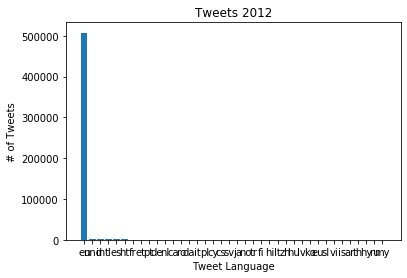

In [12]:
import matplotlib.pyplot as plt
# plots number of tweets in each language
counts = df['lang'].value_counts()
plt.bar(counts.index, counts, align='center', alpha=1)
plt.xlabel('Tweet Language')
plt.ylabel('# of Tweets')
plt.title('Tweets 2012')
print(counts.index)

In [13]:
print("Old df shape:",df.shape[0])
df = df.loc[df["lang"]=='en']
print("New df shape:",df.shape[0])

Old df shape: 520003
New df shape: 507519


In [16]:
df = df.reset_index(drop=True)

def create_date(text):
    temp = text.split(" ")
    x = str(datetime.datetime(int(temp[5]),int(strptime(temp[1],'%b').tm_mon),int(temp[2]))).split()[0]
    return x

df['date'] = df['created_at'].apply(lambda x: create_date(x))
df['time'] =  np.array([tweet.split()[3] for tweet in df["created_at"]])
df['Datetime']= pd.to_datetime(df['date'].apply(str)+' '+df['time'].apply(lambda x: x.split(':')[0]) + df['time'].apply(lambda x: x.split(':')[1]))
df['DateHour'] = pd.to_datetime(df['date'].apply(str)+' '+df['time'].apply(lambda x: x.split(':')[0])+':00')
df['DateMinutes'] = pd.to_datetime(df['date'].apply(str)+' '+df['time'].apply(lambda x: x.split(':')[0])+':'+df["time"].apply(lambda x: x.split(":")[1][0]+'0'))

tableFlag=[]
data_sorted = df.sort_values(by=['date'],inplace=False)
data_sorted = data_sorted.reset_index(drop=True)

list_date = []
for temp in data_sorted["DateHour"]:
    list_date.append(temp)

list_date = list(dict.fromkeys(list_date))
list_date = sorted(list_date)
print(len(list_date))

673


In [24]:
df_relevant['date'] = df_relevant['created_at'].apply(lambda x: create_date(x))
df_relevant['time'] =  np.array([tweet.split()[3] for tweet in df_relevant["created_at"]])
df_relevant['DateHour'] = pd.to_datetime(df_relevant['date'].apply(str)+' '+df_relevant['time'].apply(lambda x: x.split(':')[0])+':00')
    
df_irrelevant['date'] = df_irrelevant['created_at'].apply(lambda x: create_date(x))
df_irrelevant['time'] =  np.array([tweet.split()[3] for tweet in df_irrelevant["created_at"]])
df_irrelevant['DateHour'] = pd.to_datetime(df_irrelevant['date'].apply(str)+' '+df_irrelevant['time'].apply(lambda x: x.split(':')[0])+':00')

# graphing the threshold vs hourly tweet occurences
dfchange = df_irrelevant.loc[df_irrelevant['date'] != -1]
ts = dfchange.set_index('DateHour')
vc = ts.groupby('DateHour').count()
col = ['id']
vc2 = vc[col]
vc3 = vc2.copy()


dfchange1 = df_relevant.loc[df_relevant["date"]!=-1]
rs = dfchange1.set_index('DateHour')
rc = rs.groupby('DateHour').count()
col = ['id']
rc2 = rc[col]
rc3 = rc2.copy()

vc3.rename(columns={'id':'Hourly'},inplace=True)

rc3.rename(columns={'id':'Threshold'},inplace=True)

ax = vc2.plot()
rc3.plot(ax = ax)

# Flagging all potential eventful tweets

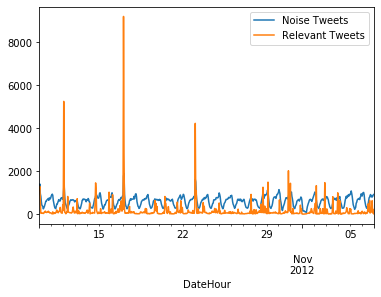

In [38]:
# gca stands for 'get current axis'
# graphing the threshold vs hourly tweet occurences
dfchange = df_irrelevant.loc[df_irrelevant['date'] != -1]
ts = dfchange.set_index('DateHour')
vc = ts.groupby('DateHour').count()
col = ['id']
vc2 = vc[col]
vc3 = vc2.copy()


dfchange1 = df_relevant.loc[df_relevant["date"]!=-1]
rs = dfchange1.set_index('DateHour')
rc = rs.groupby('DateHour').count()
col1 = ['id']
rc2 = rc[col1]
rc3 = rc2.copy()

vc3.rename(columns={'id':'Noise Tweets'},inplace=True)
rc3.rename(columns={'id':'Relevant Tweets'},inplace=True)

ax = vc3.plot()
rc3.plot(ax = ax)

In [41]:
df_relevant.shape[0]

106017

In [40]:
df_irrelevant.shape[0]

413986

<h3> Remove hashtags,mentions,retweets from the tweet and import them to a new column </h3>

In [44]:
def remove_patterns(input_txt,mentions,hashtags,RT):
    m = re.findall(mentions, input_txt)
    h = re.findall(hashtags,input_txt)
    r = re.findall(RT,input_txt)
    u = re.findall(r"http\S+",input_txt)
    mention_list = []
    hashtag_list = []
    url_list = []
    rt1 = 0
    
    
    for i in u:
        url_list.append(i)
        #input_txt = re.sub(i,'',input_txt)
    input_txt = re.sub(r"http\S+",'',input_txt)
    for i in m:
        mention_list.append(i)
        input_txt = re.sub(i, '', input_txt)
    for i in h:
        hashtag_list.append(i)
        input_txt = re.sub(i,'',input_txt)
    if r!=0 :
        rt1 = 1
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    #Some json
    x = {"input_text" : input_txt,"user_mentions":mention_list,"hashtags":hashtag_list,"is_RT":rt1,"is_URL":url_list}
    #y = json.dumps(x)
    return x

def list_lower(temp):
    list_lower =[]
    for text in temp:
        list_lower.append(text.lower())
    return list_lower

temp = np.vectorize(remove_patterns)(df['tweets'],"@[\w]*","#[\w]*","RT")

#print(df["Orig_Tweet"][12])
df["text"] = np.array([text["input_text"] for text in temp])
#df2["hashtag"] = np.array([text["hashtags"] for text in temp])
df["hashtag"] = np.array([list_lower(text["hashtags"]) for text in temp])
df["user_mentions"] = np.array([text["user_mentions"] for text in temp]) 
df["RT"] = np.array([text["is_RT"] for text in temp])
df["URL"] = np.array([text["is_URL"] for text in temp])

<h3> Remove punctuation and Tokenization</h3>

In [45]:
def remove_punct(text):
    temp = string.punctuation+"…"
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = re.split('\W+', text)
    #text = nltk.word_tokenize(text)
    temp=[]
    for i in text:
        if i!='':
            temp.append(i)
    return temp

df['Tweet_punct'] = df['text'].apply(lambda x: remove_punct(x))
df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
# df.head()

<h3>Remove stopwords</h3>

In [46]:
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))

<h3> Stemming </h3

In [47]:
# Stemming is the process of breaking a word down into its root.
stemmer = SnowballStemmer('english')
stops = set(stopwords.words("english"))

def stemming_to_sent(words):
    stemmed_words = [stemmer.stem(w) for w in words]
    return(" ".join(stemmed_words))
def stemming_to_words(words):
    stemmed_words = [stemmer.stem(w) for w in words]
    return stemmed_words

df["Stem_sent"] = np.array([stemming_to_sent(temp) for temp in df["Tweet_nonstop"]])
df["Stem_words"] = np.array([stemming_to_words(temp) for temp in df["Tweet_nonstop"]])
df["No"] = np.array([i for i in range(0,df.shape[0])])

In [48]:
def new_clean_data(i,df):
    sent = ""
    for temp in df["Stem_words"].get(i):
        sent+= temp + " "
    for temp in df["hashtag"].get(i):
        sent+= temp + " "
    for temp in df["user_mentions"].get(i):
        sent+= temp+ " "
    for temp in df["URL"].get(i):
        sent+= temp + " "
    return sent

df["clean_data"] = np.array([new_clean_data(i,df) for i in range(df.shape[0])])

In [49]:
# Function to convert   
def listToString(s):
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 

def lists_to_sentence(tokens,hashtag):
    t = tokens.copy()
    h = hashtag.copy()
    for temp in h:
        t.append(temp)
    return listToString(t)

# total_df["total_sentence"] = np.array([lists_to_sentence(row["Stem_words"],row["hashtag"]) for index,row in total_df.iterrows()])
# df

# TFIDF Vectorization

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
def getTfIdf(clean_train,windows_corpus,ngram1,ngram2,mindf,maxdf):
    if (mindf==0):
        minimum = 1
    else:
        minimum = max(int(windows_corpus * 0.0025), 10)
    if (maxdf==0):
        maximum = 1.0
    else:
        maximum = 0.8  
        
    tfidf_vectorizer = TfidfVectorizer(
                                       min_df=minimum,
                                       max_df=maximum,
                                       max_features=2000000,
                                       stop_words='english',
                                       use_idf=True,
                                       ngram_range=(ngram1,ngram2)
    )
    # Tf-idf-weighted term-document sparse matrix
    try :
        tfidf_train_data_features = tfidf_vectorizer.fit_transform(clean_train)
    except:
#         print("Hello")
        tfidf_vectorizer = TfidfVectorizer(max_features=2000000,stop_words='english',use_idf=True,ngram_range=(1,3))
        tfidf_train_data_features = tfidf_vectorizer.fit_transform(clean_train)
        minimum = 1
        maximum = 1.0
    finally:
        list_sum = []
        for i in range(0,tfidf_train_data_features.shape[0]):
            list_sum.append(tfidf_train_data_features[i].count_nonzero())
                
        return {'tfidf_train_data_features':tfidf_train_data_features,'minimum':minimum,'maximum':maximum,'sum':list_sum}

In [51]:
# function to get unique values 
def getNumClusters(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return len(unique_list)

# take second element for sort
def takeSecond(elem):
    return elem[1]

# Affinity Propagation Clustering

In [52]:
from sklearn.cluster import AffinityPropagation
def getAffinity(tweets,tfidf):
    clustering = AffinityPropagation().fit(tfidf.toarray())
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
    
    return {"clusters":clusters,"labels_pr":clustering.labels_.tolist()}
    

# KMeans Clustering

In [53]:
from sklearn.cluster import KMeans
def getKMeans(tweets,tfidf):
    clustering = KMeans(n_clusters=5,n_jobs=-1).fit(tfidf.toarray())
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
    
    return {"clusters":clusters,"labels_pr":clustering.labels_.tolist()}
    

# Hierarchical Clustering

In [54]:
from sklearn.cluster import AgglomerativeClustering
def getHierarchical(tweets,tfidf):
    clustering = AgglomerativeClustering(n_clusters=5).fit(tfidf.toarray())
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
    
    return {"clusters":clusters,"labels_pr":clustering.labels_.tolist()}
    

# HDBSCAN (Hierarchical Density-based Clustering)

In [55]:
def getHDBSCAN(tweets,tfidf):
    clustering = hdbscan.HDBSCAN(min_cluster_size=5,metric='cosine').fit(tfidf)
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
        
    #Noise Data
    noise_data = addedCluster[addedCluster['Cluster']==-1]
#     noise_data = addedCluster[addedCluster['Cluster'] == -1]
#     print("Size:",noise_data.shape[0])
#     print(noise_data["tweets"],noise_data["Event"])
    
    return {"clusters":clusters,"noise_data":noise_data,"labels_pr":clustering.labels_.tolist()}

# DBSCAN Clustering (Density-based Clustering)

In [56]:
def getDBSCAN(tweets,tfidf,e):
    clustering = DBSCAN(eps=e, min_samples=5,n_jobs=-1,metric='cosine').fit(tfidf)
    
    clusters = clustering.labels_.tolist()
    temp = clusters.copy()
    temp.remove
    
    addedCluster = tweets.copy()
    addedCluster['Cluster'] = clusters
    num_clusters = getNumClusters(clusters)

    pd.options.display.max_colwidth = 100

    cls = []
    #num_clusters = 55
    max_num_cluster = 0

    for i in range(0, num_clusters):
        tweetsInCluster = addedCluster[addedCluster['Cluster'] == i]
        if(tweetsInCluster.shape[0] > 0):
            cls.append((tweetsInCluster,tweetsInCluster.shape[0]))
            
#     cls.sort(key=takeSecond,reverse=True)
    clusters = []
    for i in range(len(cls)):
        clusters.append(cls[i][0])
        
    #Noise Data
    noise_data = addedCluster[addedCluster['Cluster']==-1]
#     noise_data = addedCluster[addedCluster['Cluster'] == -1]
#     print("Size:",noise_data.shape[0])
#     print(noise_data["tweets"],noise_data["Event"])
    
    return {"clusters":clusters,"noise_data":noise_data,"labels_pr":clustering.labels_.tolist()}

# Creation of Clusters

In [57]:
def getLabel(list_event):
    temp = list_event.value_counts()
    return temp.keys()[0]

from sklearn.preprocessing import StandardScaler
import statistics
def create_clusters(df,ngram,epsilon,mindf,maxdf,method_cl):  
    list_y_fscore = []
    list_pr_fscore = []
    adjusted_mutual_info = []
    adjusted_rand_score = []
    completeness_score = []
    fowlkes_mallows_score = []
    homogeneity_score = []
    mutual_info_score = []
    normalized_mutual_info_score = []
    v_measure_score = []
    silhouette = []
    calinski_harabasz = []
    davies_bouldin = []
    contingency = []
    count = 0
    count_labels = 0
    for current_date in list_date:
        try:
            list_y = []
            list_pr = []
            
            dfchange = df.loc[df['DateHour']==current_date]
            tweets = dfchange.sort_values(by=['time'])
            tweetsContent = tweets.copy()["clean_data"]
            tfidf_object = getTfIdf(tweetsContent,dfchange.shape[0],ngram,3,mindf,maxdf)
            tfidf = tfidf_object['tfidf_train_data_features']
            minimum = tfidf_object['minimum']
            maximum = tfidf_object['maximum']
            list_sum = tfidf_object['sum']
            tweets['sum'] = list_sum
            noise_tweets = tweets.loc[tweets['sum']==0]
            
#             print("Event",count,":")
            count+=1
#             print("Cluster_noise: ",noise_tweets.shape[0],"False Negative:",noise_tweets.loc[noise_tweets["Event"]!=-1].shape[0])
            for index,row in noise_tweets.iterrows():
                list_y_fscore.append(row["Event"])
                list_pr_fscore.append(-1)
#                 print(row["Event"]," ",end='')
#             print()
            
            train_tweets = tweets.loc[tweets['sum']!=0]
#             print("Tweets: ",train_tweets.shape[0])
            trainContent = train_tweets.copy()["clean_data"]
            
#             import pdb; pdb.set_trace()
            headline_vectorizer = CountVectorizer(binary=True, min_df=1,ngram_range=(1,1))
            tfidf = headline_vectorizer.fit_transform(trainContent)
            
            if (method_cl == 'dbscan'):
                x_object = getDBSCAN(train_tweets,tfidf,epsilon)
            elif (method_cl == 'hdbscan'):
                x_object = getHDBSCAN(train_tweets,tfidf)
            elif (method_cl == 'hierarchical'):
                x_object = getHierarchical(train_tweets,tfidf)
            elif (method_cl == 'kmeans'):
                x_object = getKMeans(train_tweets,tfidf)
            else:
                x_object = getAffinity(train_tweets,tfidf)

            candidate_cluster = x_object["clusters"]
            if (method_cl=='dbscan' or method_cl=='hdbscan'):
                candidate_noise = x_object["noise_data"]
                for index,row in candidate_noise.iterrows():
                    list_y.append(row["Event"])
                    list_pr.append(-1)
                    list_y_fscore.append(row["Event"])
                    list_pr_fscore.append(-1)
            candidate_labels= x_object["labels_pr"]
            
            
            for current_cluster in candidate_cluster:
#                 print("Cluster Label:",count_labels,current_cluster.shape[0])
                pr_event = getLabel(current_cluster["Event"])
                for index,row in current_cluster.iterrows():
                    list_y.append(row["Event"])
                    list_pr.append(count_labels)
                    list_y_fscore.append(row["Event"])
                    list_pr_fscore.append(pr_event)
#                     print(row["Event"]," ",end='')
#                 print()
                count_labels+=1

            
            from sklearn import metrics
            adjusted_mutual_info.append(metrics.adjusted_mutual_info_score(list_y,list_pr,average_method='arithmetic'))
            adjusted_rand_score.append(metrics.adjusted_rand_score(list_y,list_pr))
            completeness_score.append(metrics.completeness_score(list_y,list_pr))
            fowlkes_mallows_score.append(metrics.fowlkes_mallows_score(list_y,list_pr,sparse=False))
            homogeneity_score.append(metrics.homogeneity_score(list_y,list_pr))
            mutual_info_score.append(metrics.mutual_info_score(list_y,list_pr,contingency=None))
            normalized_mutual_info_score.append(metrics.normalized_mutual_info_score(list_y,list_pr,average_method='arithmetic'))
            v_measure_score.append(metrics.v_measure_score(list_y,list_pr))
        except Exception as e:
            print(e)
            pass
    from sklearn import metrics
    f1 = metrics.f1_score(list_y_fscore,list_pr_fscore,average='micro')
    clustering_name = ''
    num_grams = '('+str(ngram)+',3)'
    details = {'clustering_name':method_cl,'num_grams':num_grams,'epsilon':epsilon,
                   'min_df':minimum,'max_df':maximum}
    
    try:
        clustering_object =  {'f1_score':f1,'adjusted_mutual_info_score':statistics.mean(adjusted_mutual_info),'adjusted_rand_score':statistics.mean(adjusted_rand_score),
                                'completeness_score':statistics.mean(completeness_score),'fowlkes_mallows_score':statistics.mean(fowlkes_mallows_score),
                                'homogeneity_score':statistics.mean(homogeneity_score),'mutual_info_score':statistics.mean(mutual_info_score),
                                'normalized_mutual_info_score':statistics.mean(normalized_mutual_info_score),
                                 'v_measure_score':statistics.mean(v_measure_score)}

        total_result = {'parameters':details,'clustering_object':clustering_object}
        return json.dumps(total_result)
    except Exception as e:
        print(e)
        return None
    return None

In [58]:
df = df.sort_values(by=['Datetime'])

# Evaluation Metrics

In [59]:
result1 = create_clusters(df,2,0.5,1,0,'dbscan')
print(result1)

{"parameters": {"clustering_name": "dbscan", "num_grams": "(2,3)", "epsilon": 0.5, "min_df": 1, "max_df": 1.0}, "clustering_object": {"f1_score": 0.9047641566128559, "adjusted_mutual_info_score": 0.38504509425685907, "adjusted_rand_score": 0.3962618185414322, "completeness_score": 0.5696409671007676, "fowlkes_mallows_score": 0.8629620668201434, "homogeneity_score": 0.4884512363825032, "mutual_info_score": 0.2282049673838112, "normalized_mutual_info_score": 0.3993838179427191, "v_measure_score": 0.3993838179427191}}


In [60]:
result2 = create_clusters(df,2,0.5,1,0,'hdbscan')
print(result2)

Invalid shape in axis 0: 0.
{"parameters": {"clustering_name": "hdbscan", "num_grams": "(2,3)", "epsilon": 0.5, "min_df": 1, "max_df": 1.0}, "clustering_object": {"f1_score": 0.8781757494315473, "adjusted_mutual_info_score": 0.3505248211480651, "adjusted_rand_score": 0.3216521229284017, "completeness_score": 0.46186406374655664, "fowlkes_mallows_score": 0.7947307999828235, "homogeneity_score": 0.4483590479968902, "mutual_info_score": 0.21769510801147915, "normalized_mutual_info_score": 0.368542901146445, "v_measure_score": 0.368542901146445}}


In [61]:
result3 = create_clusters(df,2,0.5,1,0,'hierarchical')
print(result3)

Found array with 1 sample(s) (shape=(1, 12)) while a minimum of 2 is required by AgglomerativeClustering.
{"parameters": {"clustering_name": "hierarchical", "num_grams": "(2,3)", "epsilon": 0.5, "min_df": 1, "max_df": 1.0}, "clustering_object": {"f1_score": 0.9178176931655626, "adjusted_mutual_info_score": 0.2483919454672199, "adjusted_rand_score": 0.19254871237631846, "completeness_score": 0.22982708342167682, "fowlkes_mallows_score": 0.6165310241300128, "homogeneity_score": 0.6140819020045538, "mutual_info_score": 0.29139839813598184, "normalized_mutual_info_score": 0.28644459353711643, "v_measure_score": 0.28644459353711643}}


In [62]:
result4 = create_clusters(df,2,0.5,1,0,'kmeans')
print(result4)

C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number o

n_samples=1 should be >= n_clusters=5
{"parameters": {"clustering_name": "kmeans", "num_grams": "(2,3)", "epsilon": 0.5, "min_df": 1, "max_df": 1.0}, "clustering_object": {"f1_score": 0.9151833038434105, "adjusted_mutual_info_score": 0.22091559726152618, "adjusted_rand_score": 0.18583215043081694, "completeness_score": 0.21234045502667404, "fowlkes_mallows_score": 0.6290804351208276, "homogeneity_score": 0.5512307053313191, "mutual_info_score": 0.2653940654909257, "normalized_mutual_info_score": 0.25841523475021216, "v_measure_score": 0.25841523475021216}}


In [63]:
result5 = create_clusters(df,2,0.5,1,0,'affinity')
print(result5)

C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "
C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\affinity_propagation_.py:125: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn("All samples have mutually equal similarities. "


{"parameters": {"clustering_name": "affinity", "num_grams": "(2,3)", "epsilon": 0.5, "min_df": 1, "max_df": 1.0}, "clustering_object": {"f1_score": 0.9226866383327521, "adjusted_mutual_info_score": 0.202206762237415, "adjusted_rand_score": 0.14694256704867611, "completeness_score": 0.21175278995875968, "fowlkes_mallows_score": 0.535934835135901, "homogeneity_score": 0.6837528541365391, "mutual_info_score": 0.3057354911719173, "normalized_mutual_info_score": 0.251619486501274, "v_measure_score": 0.251619486501274}}


# Presentation of Clusters

In [64]:
from sklearn.preprocessing import StandardScaler
import statistics
def create_clusters_show(df,ngram,epsilon,mindf,maxdf,method_cl):  
    count = 0
    count_labels = 0
    for current_date in list_date[0:100]:
        try:
            list_y = []
            list_pr = []
            
            dfchange = df.loc[df['DateHour']==current_date]
            tweets = dfchange.sort_values(by=['time'])
            tweetsContent = tweets.copy()["clean_data"]
            tfidf_object = getTfIdf(tweetsContent,dfchange.shape[0],ngram,3,mindf,maxdf)
            tfidf = tfidf_object['tfidf_train_data_features']
            minimum = tfidf_object['minimum']
            maximum = tfidf_object['maximum']
            list_sum = tfidf_object['sum']
            tweets['sum'] = list_sum
            noise_tweets = tweets.loc[tweets['sum']==0]
            
            print("Event",count,":")
            count+=1
            print("Cluster_noise: ",noise_tweets.shape[0],"False Negative:",noise_tweets.loc[noise_tweets["Event"]!=-1].shape[0])
            
            train_tweets = tweets.loc[tweets['sum']!=0]
            print("Tweets: ",train_tweets.shape[0])
            trainContent = train_tweets.copy()["clean_data"]
            
#             import pdb; pdb.set_trace()
            headline_vectorizer = CountVectorizer(binary=True, min_df=1,ngram_range=(1,1))
            tfidf = headline_vectorizer.fit_transform(trainContent)
            
            if (method_cl == 'dbscan'):
                x_object = getDBSCAN(train_tweets,tfidf,epsilon)
            elif (method_cl == 'hdbscan'):
                x_object = getHDBSCAN(train_tweets,tfidf)
            elif (method_cl == 'hierarchical'):
                x_object = getHierarchical(train_tweets,tfidf)
            elif (method_cl == 'kmeans'):
                x_object = getKMeans(train_tweets,tfidf)
            else:
                x_object = getAffinity(train_tweets,tfidf)

            candidate_cluster = x_object["clusters"]
            if (method_cl=='dbscan' or method_cl=='hdbscan'):
                candidate_noise = x_object["noise_data"]

            candidate_labels= x_object["labels_pr"]
            
            
            for current_cluster in candidate_cluster:
                print("Cluster Label:",count_labels,current_cluster.shape[0])
                pr_event = getLabel(current_cluster["Event"])
                for index,row in current_cluster.iterrows():
                    print(row["Event"]," ",end='')
                print()
                count_labels+=1
                
        except Exception as e:
            print(e)
            pass

In [65]:
dbscan_show = create_clusters_show(df,2,0.5,1,0,'dbscan')

Event 0 :
Cluster_noise:  1442 False Negative: 362
Tweets:  802
Cluster Label: 0 278
394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  501  501  394  394  394  394  394  394  394  394  394  394  394  394  394  394  -1  394  394  394  394  -1  394  394  394  394  394  394  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  394

Event 2 :
Cluster_noise:  1036 False Negative: 126
Tweets:  548
Cluster Label: 13 474
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18

Cluster_noise:  285 False Negative: 35
Tweets:  29
Cluster Label: 62 13
422  422  422  422  422  422  422  422  422  422  422  422  422  
Cluster Label: 63 6
239  239  426  426  239  239  
Event 34 :
Cluster_noise:  376 False Negative: 34
Tweets:  84
Cluster Label: 64 50
106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  
Cluster Label: 65 18
419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  
Cluster Label: 66 5
426  239  239  426  239  
Event 35 :
Cluster_noise:  484 False Negative: 47
Tweets:  159
Cluster Label: 67 125
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  -1 

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

1  1  1  1  1  1  1  1  
Cluster Label: 103 15
1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  
Cluster Label: 104 10
1  1  1  1  1  1  1  1  1  1  
Cluster Label: 105 10
85  85  85  85  85  85  85  85  85  85  
Cluster Label: 106 6
85  1  1  85  1  1  
Cluster Label: 107 6
85  85  1  1  1  1  
Cluster Label: 108 6
1  1  1  1  85  85  
Cluster Label: 109 11
1  1  1  1  1  1  1  1  -1  1  1  
Cluster Label: 110 5
1  1  -1  1  1  
Cluster Label: 111 6
1  1  1  1  1  1  
Cluster Label: 112 6
1  1  1  1  1  1  
Event 50 :
Cluster_noise:  1412 False Negative: 328
Tweets:  1259
Cluster Label: 113 469
1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

Event 63 :
Cluster_noise:  1 False Negative: 0
Tweets:  715
Cluster Label: 139 8
2  2  2  2  2  2  2  2  
Cluster Label: 140 10
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 141 8
477  282  282  477  477  282  477  282  
Cluster Label: 142 5
472  472  472  472  472  
Cluster Label: 143 5
426  426  -1  426  426  
Event 64 :
Cluster_noise:  660 False Negative: 45
Tweets:  19
Cluster Label: 144 18
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Event 65 :
Cluster_noise:  690 False Negative: 61
Tweets:  10
Cluster Label: 145 10
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Event 66 :
Cluster_noise:  711 False Negative: 71
Tweets:  16
Cluster Label: 146 8
477  282  282  477  477  282  477  282  
Event 67 :
Cluster_noise:  808 False Negative: 156
Tweets:  47
Cluster Label: 147 5
477  477  477  477  477  
Event 68 :
Cluster_noise:  788 False Negative: 150
Tweets:  147
Cluster Label: 148 12
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 149 30
86 

In [66]:
hdbscan_show = create_clusters_show(df,2,0.5,1,0,'hdbscan')

Event 0 :
Cluster_noise:  1442 False Negative: 362
Tweets:  802
Cluster Label: 0 20
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  501  501  
Cluster Label: 1 6
487  487  487  487  394  394  
Cluster Label: 2 6
394  394  -1  394  394  -1  
Cluster Label: 3 12
501  501  487  487  394  394  394  394  487  487  394  394  
Cluster Label: 4 5
-1  -1  19  19  -1  
Cluster Label: 5 16
487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  
Cluster Label: 6 14
-1  487  487  487  487  487  487  487  487  487  487  487  487  -1  
Cluster Label: 7 61
487  487  -1  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  
Cluster Label: 8 8
-1  19  19  -1  394  394  394  394  
Cluster Label: 9 6
-1  -1

Event 3 :
Cluster_noise:  842 False Negative: 28
Tweets:  13
Event 4 :
Cluster_noise:  614 False Negative: 34
Tweets:  12
Event 5 :
Cluster_noise:  1 False Negative: 0
Tweets:  447
Cluster Label: 134 414
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  382  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  245  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  -1  -1  -1  75  -1  -1  -1  -1  -1  241  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  75  -1  -1  383  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  240  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  420  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  241  383  

Cluster Label: 168 10
75  75  75  75  75  75  75  75  75  75  
Cluster Label: 169 15
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 170 24
239  239  239  238  238  380  380  239  239  380  239  239  426  239  380  380  426  426  426  239  426  239  239  426  
Cluster Label: 171 15
246  246  246  246  246  246  246  246  246  246  246  246  246  246  246  
Event 21 :
Cluster_noise:  763 False Negative: 37
Tweets:  31
Cluster Label: 172 16
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 173 15
239  239  239  426  239  426  420  420  426  426  239  420  426  239  239  
Event 22 :
Cluster_noise:  732 False Negative: 56
Tweets:  17
Event 23 :
Cluster_noise:  797 False Negative: 44
Tweets:  13
Event 24 :
Cluster_noise:  866 False Negative: 27
Tweets:  13
Event 25 :
Cluster_noise:  871 False Negative: 18
Tweets:  22
Cluster Label: 174 10
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 175 12
-1  -1  -1  -1  -1  -1  -1  -1  -

Event 33 :
Cluster_noise:  285 False Negative: 35
Tweets:  29
Cluster Label: 184 16
422  422  422  422  422  422  422  422  422  422  422  422  422  422  422  422  
Cluster Label: 185 11
239  426  239  239  239  239  426  426  239  239  239  
Event 34 :
Cluster_noise:  376 False Negative: 34
Tweets:  84
Cluster Label: 186 56
106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  106  
Cluster Label: 187 10
239  239  239  239  239  426  239  239  426  239  
Cluster Label: 188 18
419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  419  
Event 35 :
Cluster_noise:  484 False Negative: 47
Tweets:  159
Cluster Label: 189 14
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 190 131
0  0  0  0  0  0  0  0  0  0  0  0  0  0 

1  1  1  1  1  1  1  1  1  1  1  1  85  85  85  85  1  
Cluster Label: 300 8
1  1  -1  1  1  1  1  1  
Cluster Label: 301 9
1  1  -1  -1  1  1  1  1  1  
Cluster Label: 302 13
1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 303 10
1  1  1  1  1  1  1  1  1  1  
Cluster Label: 304 6
1  1  1  1  1  1  
Cluster Label: 305 12
1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 306 13
1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 307 11
1  85  85  85  1  1  85  1  1  1  1  
Cluster Label: 308 12
1  1  1  1  1  1  1  1  1  1  1  -1  
Cluster Label: 309 6
1  1  1  1  1  1  
Cluster Label: 310 8
1  1  1  1  1  1  1  1  
Cluster Label: 311 10
1  1  1  1  1  1  1  1  1  1  
Cluster Label: 312 7
1  1  1  1  1  1  1  
Cluster Label: 313 9
1  1  1  1  1  1  1  1  1  
Cluster Label: 314 8
-1  1  1  -1  1  1  1  1  
Cluster Label: 315 18
1  1  1  1  1  -1  1  1  1  1  -1  1  1  -1  1  1  1  1  
Cluster Label: 316 5
1  1  1  1  1  
Cluster Label: 317 10
1  1  1  1  1  1  1  1  1  1  
C

1  1  1  1  1  
Cluster Label: 447 8
1  1  1  1  1  1  1  1  
Cluster Label: 448 8
1  1  1  1  1  1  1  1  
Cluster Label: 449 25
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 450 5
1  1  1  1  1  
Cluster Label: 451 19
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 452 12
1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 453 5
1  1  1  1  -1  
Cluster Label: 454 10
1  1  1  1  1  1  1  1  1  1  
Cluster Label: 455 10
1  1  1  1  1  1  1  1  1  1  
Cluster Label: 456 10
1  1  1  1  1  1  1  1  1  1  
Cluster Label: 457 20
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 458 6
1  1  1  1  1  1  
Cluster Label: 459 15
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 460 13
1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 461 16
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 462 6
1  1  1  1  1  1  
Cluster Label: 463 10
1  1  1  1  1  1  1  1  1  1  
Clus

Event 55 :
Cluster_noise:  370 False Negative: 58
Tweets:  45
Cluster Label: 537 12
0  2  0  2  0  2  2  2  0  0  0  0  
Cluster Label: 538 18
89  -1  89  89  89  89  280  89  89  280  89  280  89  280  89  280  89  280  
Cluster Label: 539 15
148  148  148  148  148  148  148  148  148  148  148  148  148  148  148  
Event 56 :
Cluster_noise:  282 False Negative: 33
Tweets:  73
Cluster Label: 540 25
2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  2  2  2  -1  -1  0  
Cluster Label: 541 12
89  280  280  89  89  280  280  89  280  280  89  89  
Cluster Label: 542 8
280  89  280  89  280  89  280  89  
Cluster Label: 543 17
89  89  280  280  89  280  89  89  280  280  89  280  89  280  89  280  89  
Event 57 :
Cluster_noise:  301 False Negative: 47
Tweets:  782
Cluster Label: 544 22
88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  
Cluster Label: 545 12
2  2  2  2  2  2  2  2  2  2  2  2  
Cluster Label: 546 7
2  2  2  2  2  2  2  
Cluster 

Event 69 :
Cluster_noise:  709 False Negative: 83
Tweets:  82
Cluster Label: 609 15
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 610 15
284  480  284  480  480  480  480  284  284  480  480  480  284  480  284  
Cluster Label: 611 6
79  79  79  79  79  79  
Cluster Label: 612 9
79  79  79  79  79  79  79  79  79  
Cluster Label: 613 5
79  79  79  79  79  
Event 70 :
Cluster_noise:  655 False Negative: 47
Tweets:  12
Event 71 :
Cluster_noise:  600 False Negative: 40
Tweets:  12
Event 72 :
Cluster_noise:  706 False Negative: 125
Tweets:  11
Event 73 :
Cluster_noise:  1 False Negative: 0
Tweets:  707
Cluster Label: 614 668
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  480  284  480  284  284  480  480  284  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  474  -1  -1  -1  -1  -1  -1  -1

Event 76 :
Cluster_noise:  1014 False Negative: 416
Tweets:  288
Cluster Label: 620 6
3  3  3  3  3  3  
Cluster Label: 621 8
3  3  3  3  3  3  3  3  
Cluster Label: 622 5
3  3  3  3  3  
Cluster Label: 623 52
505  505  505  505  3  3  505  505  3  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  
Cluster Label: 624 5
505  505  505  505  505  
Cluster Label: 625 5
3  3  3  3  -1  
Cluster Label: 626 6
3  3  3  3  3  3  
Cluster Label: 627 7
3  3  3  3  3  3  3  
Cluster Label: 628 5
3  3  3  3  3  
Cluster Label: 629 11
3  3  3  3  3  3  3  3  3  3  3  
Cluster Label: 630 7
3  3  3  3  3  3  3  
Cluster Label: 631 5
3  3  3  3  3  
Cluster Label: 632 7
3  3  3  3  3  3  3  
Cluster Label: 633 6
3  3  3  3  3  3  
Cluster Label: 634 7
3  3  3  3  3  3  3  
Cluster Label: 635 12
3  -1  3  3  3  3  3  3  3  3  3  3  
Cluster 

Event 85 :
Cluster_noise:  526 False Negative: 42
Tweets:  10
Event 86 :
Cluster_noise:  683 False Negative: 58
Tweets:  34
Cluster Label: 655 20
480  480  284  284  480  284  480  284  284  284  480  480  480  480  284  284  284  480  480  284  
Cluster Label: 656 14
278  278  278  278  278  278  278  278  278  278  278  278  278  278  
Event 87 :
Cluster_noise:  679 False Negative: 49
Tweets:  16
Event 88 :
Cluster_noise:  1 False Negative: 0
Tweets:  739
Cluster Label: 657 703
4  -1  474  -1  -1  -1  -1  -1  -1  -1  275  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  282  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  4  -1  -1  -1  -1  -1  -1  -1  474  -1  -1  -1  -1  -1  -1  -1  282  -1  -1  -1  -1  -1  -1  -1  -1  -1  285  -1  -1  4  -1  4  -1  -1  -1  280  -1  -1  474  -1  -1  -1  -1  -1  278  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1

In [67]:
hierarchical = create_clusters_show(df,2,0.5,1,0,'hierarchical')

Event 0 :
Cluster_noise:  1442 False Negative: 362
Tweets:  802
Cluster Label: 0 121
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  394  394  394  394  394  394  501  501  394  394  394  394  394  394  394  394  394  394  501  501  501  501  394  394  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  501  -1  501  501  501  501  501  501  501  501  501  501  -1  501  501  501  501  501  501  -1  501  501  501  501  -1  501  501  394  394  -1  -1  -1  501  501  -1  -1  -1  487  487  487  487  501  501  394  394  -1  -1  -1  -1  394  394  -1  
Cluster Label: 1 207
19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  -1  19  19  -1  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  1

Event 2 :
Cluster_noise:  1036 False Negative: 126
Tweets:  548
Cluster Label: 10 305
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  -1  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18

Event 11 :
Cluster_noise:  451 False Negative: 37
Tweets:  51
Cluster Label: 55 15
241  241  241  241  241  241  241  241  241  241  241  241  241  241  241  
Cluster Label: 56 6
383  383  383  383  383  383  
Cluster Label: 57 23
386  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  243  
Cluster Label: 58 3
243  243  243  
Cluster Label: 59 4
383  383  383  383  
Event 12 :
Cluster_noise:  525 False Negative: 36
Tweets:  97
Cluster Label: 60 35
240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  
Cluster Label: 61 17
243  243  243  243  243  243  243  386  243  243  243  243  243  243  243  386  243  
Cluster Label: 62 17
241  241  241  241  241  241  241  241  241  241  241  241  241  241  241  241  241  
Cluster Label: 63 17
240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  24

Event 27 :
Cluster_noise:  910 False Negative: 66
Tweets:  50
Cluster Label: 135 18
77  77  77  77  -1  -1  -1  77  77  -1  -1  77  77  -1  -1  -1  77  77  
Cluster Label: 136 15
-1  77  77  77  77  77  77  77  77  77  77  77  77  77  77  
Cluster Label: 137 4
77  77  77  77  
Cluster Label: 138 8
422  422  422  422  422  422  422  422  
Cluster Label: 139 5
422  422  422  422  422  
Event 28 :
Cluster_noise:  0 False Negative: 0
Tweets:  650
Cluster Label: 140 127
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 141 39

Event 42 :
Cluster_noise:  661 False Negative: 57
Tweets:  258
Cluster Label: 210 19
426  239  239  426  239  426  426  239  239  239  426  239  426  239  239  426  239  426  426  
Cluster Label: 211 56
83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  
Cluster Label: 212 156
83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  -1  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  -1  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  8

1  1  1  1  -1  1  1  -1  -1  1  1  -1  -1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  -1  -1  1  1  1  1  1  1  1  -1  1  1  85  1  1  1  1  1  -1  85  -1  1  1  1  1  85  1  1  1  1  1  1  1  1  1  1  85  1  1  85  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  85  85  1  1  1  1  1  1  85  1  1  -1  1  1  -1  1  1  1  -1  1  1  85  1  1  85  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  85  85  1  1  1  1  1  1  1  1  1  1  1  1  85  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  -1  -1  1  1  -1  1  1  1  1  1  1  -1  1  1  
Cluster Label: 252 201
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  424  -1  2  2  2  2  2  2  2  2  2  2  2  2  2  -1  2  2  -1  2  -1  2  2  2  2  2  2  2  2  2  2  2  
Cluster Label: 289 22
88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  88  
Event 58 :
Cluster_noise:  389 False Negative: 50
Tweets:  46
Cluster Label: 290 13
2  2  2  2  2  2  2  2  2  -1  2  2  2  
Cluster Label: 291 6
478  478  478  478  478  478  
Cluster Label: 292 8
478  478  478  478  478  478  478  478  
Cluster Label: 293 6
478  478  478  478  478  478  
Cluster Label: 294 13
2  2  2  2  2  2  2  2  2  2  2  2  2  
Event 59 :
Cluster_noise:  460 False Negative: 51
Tweets:  41
Cluster Label:

Cluster Label: 365 495
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  3  -1  3  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  276  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1

Event 76 :
Cluster_noise:  1014 False Negative: 416
Tweets:  288
Cluster Label: 380 98
3  3  3  3  3  3  -1  3  -1  3  3  3  3  3  3  3  3  3  3  3  -1  3  3  3  3  3  3  3  94  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  -1  94  3  3  -1  3  3  3  3  3  -1  
Cluster Label: 381 64
505  505  505  505  3  3  505  505  3  505  -1  505  3  505  505  505  505  3  505  505  3  505  505  505  505  505  505  3  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  
Cluster Label: 382 48
3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  
Cluster Label: 383 35
3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  -1  3  3  3  3  3  3  3  3  3  3

Event 84 :
Cluster_noise:  435 False Negative: 39
Tweets:  12
Cluster Label: 420 4
280  280  280  280  
Cluster Label: 421 2
280  280  
Cluster Label: 422 3
280  280  280  
Cluster Label: 423 2
280  280  
Cluster Label: 424 1
280  
Event 85 :
Cluster_noise:  526 False Negative: 42
Tweets:  10
Cluster Label: 425 3
-1  -1  -1  
Cluster Label: 426 1
-1  
Cluster Label: 427 4
-1  -1  -1  -1  
Cluster Label: 428 1
-1  
Cluster Label: 429 1
-1  
Event 86 :
Cluster_noise:  683 False Negative: 58
Tweets:  34
Cluster Label: 430 2
278  278  
Cluster Label: 431 16
480  480  284  284  480  284  480  284  284  284  480  480  284  480  480  284  
Cluster Label: 432 4
480  480  284  284  
Cluster Label: 433 7
278  278  278  278  278  278  278  
Cluster Label: 434 5
278  278  278  278  278  
Event 87 :
Cluster_noise:  679 False Negative: 49
Tweets:  16
Cluster Label: 435 3
480  284  480  
Cluster Label: 436 4
480  284  480  284  
Cluster Label: 437 4
284  284  480  480  
Cluster Label: 438 4
480  284 

Cluster Label: 470 6
71  71  71  71  71  71  
Cluster Label: 471 4
283  283  283  283  
Cluster Label: 472 3
71  71  71  
Cluster Label: 473 6
283  283  283  283  283  283  
Cluster Label: 474 18
71  71  71  71  71  71  71  71  71  71  71  71  71  71  71  71  71  71  
Event 95 :
Cluster_noise:  709 False Negative: 67
Tweets:  20
Cluster Label: 475 10
71  71  71  71  71  71  71  71  71  71  
Cluster Label: 476 5
71  71  71  71  71  
Cluster Label: 477 2
71  71  
Cluster Label: 478 2
71  71  
Cluster Label: 479 1
71  
Event 96 :
Cluster_noise:  762 False Negative: 140
Tweets:  39
Cluster Label: 480 2
4  4  
Cluster Label: 481 21
4  4  4  4  4  4  4  4  4  4  4  4  4  4  -1  4  4  4  4  4  4  
Cluster Label: 482 1
-1  
Cluster Label: 483 1
4  
Cluster Label: 484 14
4  4  4  4  -1  4  4  4  4  4  4  4  4  4  
Event 97 :
Cluster_noise:  674 False Negative: 21
Tweets:  32
Cluster Label: 485 8
71  71  71  71  71  71  71  71  
Cluster Label: 486 4
71  71  71  71  
Cluster Label: 487 4
71  71  

In [68]:
kmeans = create_clusters_show(df,2,0.5,1,0,'kmeans')

Event 0 :
Cluster_noise:  1442 False Negative: 362
Tweets:  802
Cluster Label: 0 102
487  487  -1  487  487  -1  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  487  -1  -1  487  487  
Cluster Label: 1 60
19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  
Cluster Label: 2 170
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  394  394  394  394  394  394  501  501  394  394  394  394  394  394  394  394  394  3

Event 2 :
Cluster_noise:  1036 False Negative: 126
Tweets:  548
Cluster Label: 10 129
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  
Cluster Label: 11 232
18  18  18  18  18  18  18  18  75  75  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  -1  18  18  18  18  18  18  -1  18  18  18  18  18  -1  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  75  75  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18 

C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Cluster Label: 20 4
238  238  380  380  
Cluster Label: 21 4
238  380  238  380  
Cluster Label: 22 4
238  380  380  238  
Event 5 :
Cluster_noise:  1 False Negative: 0
Tweets:  447
Cluster Label: 23 33
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 24 4
238  380  238  380  
Cluster Label: 25 299
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  75  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  420  -1  -1  -1  75  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  383  -1  -1  -1  -1 

-1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 84 15
246  246  246  246  -1  -1  246  246  246  246  246  246  246  246  246  
Cluster Label: 85 8
246  246  246  246  246  246  246  246  
Cluster Label: 86 2
246  246  
Cluster Label: 87 9
-1  -1  -1  -1  -1  -1  -1  -1  -1  
Event 18 :
Cluster_noise:  750 False Negative: 51
Tweets:  96
Cluster Label: 88 14
239  239  239  239  238  380  239  238  239  380  238  380  380  380  
Cluster Label: 89 37
239  239  239  239  426  239  426  239  239  426  426  239  239  239  239  426  239  426  239  426  239  426  239  239  426  426  426  426  239  239  239  239  239  426  239  426  426  
Cluster Label: 90 13
246  246  246  246  246  246  -1  246  246  246  246  246  246  
Cluster Label: 91 19
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 92 13
380  239  380  238  238  238  239  380  239  426  239  426  239  
Event 19 :
Cluster_noise:  663 False Negative: 31
Tweets:  51
Cluster Label: 93 12
239  426

Event 29 :
Cluster_noise:  545 False Negative: 51
Tweets:  14
Cluster Label: 143 6
503  503  503  503  503  503  
Cluster Label: 144 2
503  503  
Cluster Label: 145 2
503  503  
Cluster Label: 146 2
503  503  
Cluster Label: 147 2
503  503  
Event 30 :
Cluster_noise:  408 False Negative: 22
Tweets:  10
Cluster Label: 148 1
246  
Cluster Label: 149 3
246  246  246  
Cluster Label: 150 3
246  246  246  
Cluster Label: 151 2
246  246  
Cluster Label: 152 1
246  
Event 31 :
Cluster_noise:  325 False Negative: 23
Tweets:  27
Cluster Label: 153 14
239  239  239  239  239  239  239  239  239  239  239  239  239  239  
Cluster Label: 154 3
239  239  239  
Cluster Label: 155 5
426  426  426  426  426  
Cluster Label: 156 4
239  426  239  426  
Cluster Label: 157 1
239  
Event 32 :
Cluster_noise:  289 False Negative: 26
Tweets:  10
Cluster Label: 158 4
426  426  239  239  
Cluster Label: 159 1
426  
Cluster Label: 160 3
239  239  239  
Cluster Label: 161 1
239  
Cluster Label: 162 1
239  
Event 

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 237 107
21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  -1  21  21  
Event 48 :
Cluster_noise:  875 False Negative: 85
Tweets:  88
Cluster Label: 238 8
1  1  1  1  1  1  1  1  
Cluster Label: 239 32
500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  500  
Cluster Label: 240 7
1  1  1  1  1  1  -1  
Cluster Label: 241 16
1  1  1  1  1  1  1  1  1  1

1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  -1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  85  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  -1  85  1  1  85  85  1  1  85  85  1  1  1  1  1  85  -1  85  85  -1  85  85  85  85  85  85  1  1  1  85  1  1  1  1  -1  1  1  1  1  1  -1  1  1  85  1  1  1  -1  85  85  1  1  1  85  1  1  85  85  1  85  85  1  1  1  1  1  1  -1  85  1  1  85  1  1  1  1  85  85  -1  1  1  85  1  1  85  -1  1  85  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  -1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

Cluster Label: 263 89
-1  -1  279  -1  -1  -1  -1  -1  -1  -1  -1  -1  427  -1  0  -1  282  -1  0  -1  0  -1  -1  480  -1  -1  -1  -1  427  427  -1  427  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  0  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  276  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  148  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  427  427  -1  0  -1  -1  -1  -1  -1  -1  427  
Cluster Label: 264 15
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 265 4
-1  -1  -1  -1  
Cluster Label: 266 3
-1  -1  -1  
Cluster Label: 267 359
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  420  -1 

Event 63 :
Cluster_noise:  1 False Negative: 0
Tweets:  715
Cluster Label: 313 10
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 314 470
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  474  -1  -1  -1  -1  -1  -1  -1  -1  479  -1  -1  -1  -1  -1  -1  -1  -1  -1  2  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  2  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  426  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  2  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1

C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Event 67 :
Cluster_noise:  808 False Negative: 156
Tweets:  47
Cluster Label: 332 21
91  91  91  91  91  91  91  91  91  91  91  91  91  91  91  91  91  91  91  91  91  
Cluster Label: 333 16
91  91  91  91  91  91  -1  91  -1  -1  -1  -1  91  91  91  91  
Cluster Label: 334 5
477  477  477  477  477  
Cluster Label: 335 1
-1  
Cluster Label: 336 4
282  282  477  477  
Event 68 :
Cluster_noise:  788 False Negative: 150
Tweets:  147
Cluster Label: 337 20
92  92  92  92  92  92  92  92  92  92  92  92  92  92  92  92  92  92  92  92  
Cluster Label: 338 53
80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  -1  80  80  80  80  80  80  80  80  
Cluster Label: 339 30
86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86  
Cluster Label: 340 32
480  480  284  284  284  480  480  284  284  480  480  284  2

C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Event 72 :
Cluster_noise:  706 False Negative: 125
Tweets:  11
Cluster Label: 355 7
475  475  475  475  475  475  475  
Cluster Label: 356 1
475  
Cluster Label: 357 1
475  
Cluster Label: 358 1
475  
Cluster Label: 359 1
475  
Event 73 :
Cluster_noise:  1 False Negative: 0
Tweets:  707
Cluster Label: 360 8
3  3  3  -1  3  -1  -1  3  
Cluster Label: 361 150
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  480  284  480  284  284  480  480  284  -1  -1  -1  -1  -1  -1  474  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  472  -1  474  -1  -1  -1  -1  274  -1  -1  -1  278  -1  -1  -1  -1  278  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  3  474  -1  -1  -1  -1  -1  -1  -1  -1  -1  480  -1  -1  -1  -1  -1  474  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  479  -1  -1  3  -1  -1  -1  -1  -1  279  279  275  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  472  -1  -1  -1  -1  -1  -1  -1  -1  -1  279  -1  -1  -1  -1  -1  -1  -1  2  -1  -1  -1  -1  -1  465  474  -1  -1  
Cluster Label: 362 

Event 76 :
Cluster_noise:  1014 False Negative: 416
Tweets:  288
Cluster Label: 375 38
3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  
Cluster Label: 376 62
505  505  505  505  3  3  505  505  3  505  -1  505  3  505  505  505  505  3  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  505  
Cluster Label: 377 82
3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  -1  3  -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  -1  94  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  -1  94  -1  3  3  3  3  -1  
Cluster Label: 378 38
3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  
Cluster Label: 379 68
3  3  3  3  3  3  3  3  3  3  3  3  3  3

Cluster Label: 410 15
278  278  278  278  278  278  278  278  278  278  278  278  278  278  278  
Cluster Label: 411 14
282  282  282  282  282  282  282  282  282  282  282  282  282  282  
Cluster Label: 412 4
278  278  278  278  
Cluster Label: 413 1
278  
Cluster Label: 414 1
-1  
Event 84 :
Cluster_noise:  435 False Negative: 39
Tweets:  12
Cluster Label: 415 1
280  
Cluster Label: 416 3
280  280  280  
Cluster Label: 417 4
280  280  280  280  
Cluster Label: 418 2
280  280  
Cluster Label: 419 2
280  280  
Event 85 :
Cluster_noise:  526 False Negative: 42
Tweets:  10
Cluster Label: 420 2
-1  -1  
Cluster Label: 421 1
-1  
Cluster Label: 422 5
-1  -1  -1  -1  -1  
Cluster Label: 423 1
-1  
Cluster Label: 424 1
-1  
Event 86 :
Cluster_noise:  683 False Negative: 58
Tweets:  34
Cluster Label: 425 4
480  480  284  284  
Cluster Label: 426 11
278  278  278  278  278  278  278  278  278  278  278  
Cluster Label: 427 16
480  480  284  284  480  284  480  284  284  284  480  480  284  4

C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Event 88 :
Cluster_noise:  1 False Negative: 0
Tweets:  739
Cluster Label: 434 544
4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  282  -1  -1  -1  -1  -1  -1  -1  -1  -1  285  -1  -1  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  

C:\Users\giann\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Cluster Label: 439 4
480  284  480  284  
Cluster Label: 440 4
480  284  284  480  
Cluster Label: 441 4
480  480  284  284  
Cluster Label: 442 4
480  480  284  284  
Event 90 :
Cluster_noise:  707 False Negative: 31
Tweets:  10
Cluster Label: 443 1
278  
Cluster Label: 444 5
278  278  278  278  278  
Cluster Label: 445 1
278  
Cluster Label: 446 2
278  278  
Cluster Label: 447 1
278  
Event 91 :
Cluster_noise:  716 False Negative: 33
Tweets:  13
Cluster Label: 448 3
280  280  280  
Cluster Label: 449 4
280  280  280  280  
Cluster Label: 450 3
280  280  280  
Cluster Label: 451 2
280  280  
Cluster Label: 452 1
280  
Event 92 :
Cluster_noise:  1 False Negative: 0
Tweets:  694
Cluster Label: 453 1
-1  
Cluster Label: 454 140
-1  -1  -1  -1  -1  -1  -1  274  480  480  284  284  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  472  -1  -1  -1  -1  472  -1  -1  -1  -1  -1  -1  -1  -1  -1  280  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  278  -1  -1  -1  279  -1  

In [69]:
affinity = create_clusters_show(df,2,0.5,1,0,'affinity')

Event 0 :
Cluster_noise:  1442 False Negative: 362
Tweets:  802
Cluster Label: 0 34
394  394  394  -1  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  
Cluster Label: 1 172
394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  -1  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  -1  394  394  394  -1  -1  394  394  394  394  394  394  394  394  394  394  394  394  39

504  504  
Cluster Label: 160 9
504  504  504  504  504  504  504  504  -1  
Cluster Label: 161 2
504  504  
Cluster Label: 162 2
504  504  
Cluster Label: 163 2
504  504  
Cluster Label: 164 2
502  502  
Cluster Label: 165 4
504  504  504  504  
Cluster Label: 166 2
502  502  
Cluster Label: 167 6
504  504  504  504  504  504  
Cluster Label: 168 10
504  504  504  504  504  504  504  504  504  504  
Cluster Label: 169 2
504  504  
Cluster Label: 170 1
-1  
Cluster Label: 171 16
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  
Cluster Label: 172 10
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 173 1
-1  
Cluster Label: 174 2
504  504  
Cluster Label: 175 11
504  504  504  504  504  504  504  504  504  504  504  
Cluster Label: 176 6
18  18  18  18  18  18  
Cluster Label: 177 1
-1  
Cluster Label: 178 2
75  75  
Cluster Label: 179 2
18  18  
Cluster Label: 180 20
18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  
Cluster Label: 18

75  75  75  75  75  75  75  75  
Cluster Label: 346 1
18  
Cluster Label: 347 1
18  
Cluster Label: 348 2
18  18  
Cluster Label: 349 2
18  18  
Cluster Label: 350 14
18  18  18  18  18  18  18  18  18  18  18  18  18  18  
Cluster Label: 351 3
-1  18  18  
Cluster Label: 352 2
18  18  
Cluster Label: 353 1
75  
Cluster Label: 354 2
18  18  
Cluster Label: 355 2
18  18  
Cluster Label: 356 2
18  18  
Cluster Label: 357 2
18  18  
Cluster Label: 358 1
-1  
Cluster Label: 359 2
18  18  
Cluster Label: 360 1
75  
Cluster Label: 361 1
75  
Cluster Label: 362 2
18  18  
Cluster Label: 363 1
75  
Cluster Label: 364 1
75  
Event 3 :
Cluster_noise:  842 False Negative: 28
Tweets:  13
Cluster Label: 365 2
75  75  
Cluster Label: 366 6
75  75  75  75  75  75  
Cluster Label: 367 3
75  75  75  
Cluster Label: 368 2
75  75  
Event 4 :
Cluster_noise:  614 False Negative: 34
Tweets:  12
Cluster Label: 369 8
238  380  380  238  238  380  238  380  
Cluster Label: 370 4
238  238  380  380  
Event 5 :


Cluster Label: 455 14
243  243  243  243  243  243  386  243  243  243  243  243  386  243  
Cluster Label: 456 17
240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  240  
Cluster Label: 457 11
243  243  243  243  243  243  243  243  243  243  243  
Cluster Label: 458 4
240  240  240  240  
Cluster Label: 459 5
241  241  241  241  241  
Cluster Label: 460 12
240  240  240  240  240  240  240  240  240  240  240  240  
Cluster Label: 461 2
240  240  
Cluster Label: 462 13
240  240  240  240  240  240  240  240  240  240  240  240  240  
Cluster Label: 463 3
243  243  243  
Cluster Label: 464 4
240  240  240  240  
Cluster Label: 465 12
241  241  241  241  241  241  241  241  241  241  241  241  
Event 13 :
Cluster_noise:  635 False Negative: 49
Tweets:  46
Cluster Label: 466 2
240  240  
Cluster Label: 467 8
240  240  240  240  240  240  240  240  
Cluster Label: 468 7
243  243  243  243  243  243  243  
Cluster Label: 469 9
240  240  240  240  240  240  240

-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  246  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  243  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  475  -1  -1  -1  -1  -1  -1  -1  -1  -1  -

Event 35 :
Cluster_noise:  484 False Negative: 47
Tweets:  159
Cluster Label: 744 15
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
Cluster Label: 745 16
0  0  0  0  0  0  0  -1  0  0  0  0  0  0  0  0  
Cluster Label: 746 8
419  419  419  419  419  419  419  419  
Cluster Label: 747 12
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 748 10
0  0  0  0  0  0  0  0  0  0  
Cluster Label: 749 9
0  0  0  0  0  0  0  0  0  
Cluster Label: 750 1
419  
Cluster Label: 751 2
0  0  
Cluster Label: 752 2
0  0  
Cluster Label: 753 12
0  0  0  0  0  0  0  0  0  0  0  0  
Cluster Label: 754 2
0  0  
Cluster Label: 755 8
0  0  0  0  0  0  0  0  
Cluster Label: 756 6
0  0  0  0  0  0  
Cluster Label: 757 8
0  0  0  0  0  0  0  0  
Cluster Label: 758 4
419  419  419  419  
Cluster Label: 759 7
0  0  0  0  0  0  0  
Cluster Label: 760 2
-1  -1  
Cluster Label: 761 5
0  0  0  0  0  
Cluster Label: 762 2
0  0  
Cluster Label: 763 12
0  0  0  0  0  0  0  0  0  0  0  0  
Cluster Label: 764 1


1  1  
Cluster Label: 933 2
1  1  
Cluster Label: 934 4
1  1  1  1  
Cluster Label: 935 2
1  1  
Cluster Label: 936 2
1  1  
Cluster Label: 937 2
1  1  
Cluster Label: 938 2
1  1  
Cluster Label: 939 6
426  426  426  426  426  426  
Cluster Label: 940 6
420  426  426  420  426  426  
Cluster Label: 941 2
1  1  
Cluster Label: 942 2
1  1  
Cluster Label: 943 2
1  1  
Cluster Label: 944 2
1  1  
Event 48 :
Cluster_noise:  875 False Negative: 85
Tweets:  88
Cluster Label: 945 2
1  1  
Cluster Label: 946 2
1  1  
Cluster Label: 947 1
1  
Cluster Label: 948 1
1  
Cluster Label: 949 2
1  1  
Cluster Label: 950 1
1  
Cluster Label: 951 1
1  
Cluster Label: 952 1
1  
Cluster Label: 953 1
1  
Cluster Label: 954 1
1  
Cluster Label: 955 1
1  
Cluster Label: 956 1
1  
Cluster Label: 957 1
1  
Cluster Label: 958 1
-1  
Cluster Label: 959 2
1  1  
Cluster Label: 960 2
1  1  
Cluster Label: 961 30
500  500  500  500  500  500  1  500  500  500  500  500  500  500  500  500  500  500  500  500  500  

-1  1  1  1  1  1  1  1  1  85  1  1  1  1  1  1  1  1  1  1  1  1  1  1  85  1  1  1  1  1  1  1  1  -1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 1134 2
1  1  
Cluster Label: 1135 2
1  1  
Cluster Label: 1136 2
1  1  
Cluster Label: 1137 23
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 1138 2
1  1  
Cluster Label: 1139 2
1  1  
Cluster Label: 1140 2
1  1  
Cluster Label: 1141 2
1  1  
Cluster Label: 1142 2
1  1  
Cluster Label: 1143 2
1  1  
Cluster Label: 1144 2
1  1  
Cluster Label: 1145 2
1  1  
Cluster Label: 1146 2
1  1  
Cluster Label: 1147 2
1  1  
Cluster Label: 1148 4
1  1  1  1  
C

Cluster Label: 1345 2
1  1  
Cluster Label: 1346 2
1  1  
Cluster Label: 1347 2
1  1  
Cluster Label: 1348 2
1  1  
Cluster Label: 1349 2
1  1  
Cluster Label: 1350 2
1  1  
Cluster Label: 1351 2
1  1  
Cluster Label: 1352 2
1  1  
Cluster Label: 1353 2
1  1  
Cluster Label: 1354 7
1  1  1  1  1  1  1  
Cluster Label: 1355 2
1  1  
Cluster Label: 1356 2
1  1  
Cluster Label: 1357 2
1  1  
Cluster Label: 1358 2
1  1  
Cluster Label: 1359 2
1  1  
Cluster Label: 1360 2
1  1  
Cluster Label: 1361 2
1  1  
Cluster Label: 1362 2
1  1  
Cluster Label: 1363 2
1  1  
Cluster Label: 1364 2
1  1  
Cluster Label: 1365 10
1  1  85  1  1  1  1  1  1  -1  
Cluster Label: 1366 2
1  1  
Cluster Label: 1367 2
1  1  
Cluster Label: 1368 2
1  1  
Cluster Label: 1369 18
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 1370 2
1  1  
Cluster Label: 1371 2
1  1  
Cluster Label: 1372 2
1  1  
Cluster Label: 1373 12
-1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 1374 2
1  1  
Cluster

1  1  
Cluster Label: 1595 2
1  1  
Cluster Label: 1596 5
1  1  1  1  1  
Cluster Label: 1597 1
1  
Cluster Label: 1598 2
1  1  
Cluster Label: 1599 1
1  
Cluster Label: 1600 2
1  1  
Cluster Label: 1601 8
1  1  1  1  1  1  1  1  
Cluster Label: 1602 2
1  1  
Cluster Label: 1603 2
1  1  
Cluster Label: 1604 2
1  1  
Cluster Label: 1605 17
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  1  -1  -1  -1  -1  -1  
Cluster Label: 1606 21
1  1  1  1  1  1  -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 1607 2
1  1  
Cluster Label: 1608 12
1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 1609 15
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
Cluster Label: 1610 1
1  
Cluster Label: 1611 1
1  
Cluster Label: 1612 2
1  1  
Cluster Label: 1613 2
1  1  
Cluster Label: 1614 3
427  427  427  
Cluster Label: 1615 3
427  427  427  
Cluster Label: 1616 2
1  1  
Cluster Label: 1617 2
1  1  
Cluster Label: 1618 2
1  1  
Cluster Label: 1619 2
1  1  
Cluster Label: 1620 2
1  1  
Cluster Label:

Cluster Label: 1782 1
-1  
Cluster Label: 1783 1
-1  
Cluster Label: 1784 1
-1  
Cluster Label: 1785 1
-1  
Cluster Label: 1786 1
421  
Cluster Label: 1787 3
426  426  426  
Cluster Label: 1788 1
-1  
Cluster Label: 1789 37
-1  -1  -1  -1  -1  -1  -1  88  -1  423  -1  -1  -1  -1  -1  -1  -1  88  -1  -1  -1  -1  -1  -1  -1  148  148  -1  -1  -1  -1  -1  -1  -1  88  -1  -1  
Cluster Label: 1790 1
-1  
Cluster Label: 1791 3
0  0  0  
Cluster Label: 1792 1
-1  
Cluster Label: 1793 2
-1  -1  
Cluster Label: 1794 1
-1  
Cluster Label: 1795 1
-1  
Cluster Label: 1796 1
-1  
Cluster Label: 1797 1
-1  
Cluster Label: 1798 1
-1  
Cluster Label: 1799 1
-1  
Cluster Label: 1800 1
-1  
Cluster Label: 1801 3
424  424  424  
Cluster Label: 1802 1
421  
Cluster Label: 1803 1
-1  
Cluster Label: 1804 1
-1  
Cluster Label: 1805 281
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  423  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -

2  2  2  2  
Cluster Label: 1976 2
2  2  
Cluster Label: 1977 3
2  2  2  
Cluster Label: 1978 2
2  2  
Cluster Label: 1979 3
2  2  2  
Cluster Label: 1980 2
2  2  
Cluster Label: 1981 2
2  2  
Cluster Label: 1982 6
2  2  2  2  2  2  
Cluster Label: 1983 2
2  2  
Cluster Label: 1984 10
2  2  2  2  2  2  2  2  2  2  
Event 58 :
Cluster_noise:  389 False Negative: 50
Tweets:  46
Cluster Label: 1985 16
2  2  2  2  2  2  2  2  2  2  2  2  -1  2  2  2  
Cluster Label: 1986 10
2  2  2  2  2  2  2  2  2  2  
Cluster Label: 1987 1
478  
Cluster Label: 1988 2
478  478  
Cluster Label: 1989 7
478  478  478  478  478  478  478  
Cluster Label: 1990 10
478  478  478  478  478  478  478  478  478  478  
Event 59 :
Cluster_noise:  460 False Negative: 51
Tweets:  41
Cluster Label: 1991 2
2  2  
Cluster Label: 1992 9
478  478  478  478  478  478  478  478  478  
Cluster Label: 1993 3
0  0  0  
Cluster Label: 1994 11
2  2  2  2  2  2  2  2  2  2  2  
Cluster Label: 1995 7
478  478  478  478  478  478  4

Event 70 :
Cluster_noise:  655 False Negative: 47
Tweets:  12
Cluster Label: 2103 4
480  284  480  284  
Cluster Label: 2104 4
284  480  284  480  
Cluster Label: 2105 4
284  480  284  480  
Event 71 :
Cluster_noise:  600 False Negative: 40
Tweets:  12
Cluster Label: 2106 1
279  
Cluster Label: 2107 1
279  
Cluster Label: 2108 8
279  279  279  279  279  279  279  279  
Cluster Label: 2109 2
279  279  
Event 72 :
Cluster_noise:  706 False Negative: 125
Tweets:  11
Cluster Label: 2110 2
475  475  
Cluster Label: 2111 7
475  475  475  475  475  475  475  
Cluster Label: 2112 1
475  
Cluster Label: 2113 1
475  
Event 73 :
Cluster_noise:  1 False Negative: 0
Tweets:  707
Cluster Label: 2114 20
-1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  
Cluster Label: 2115 222
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  3  -1  -1  3  -1  -1  -1  -1  -1 

Cluster Label: 2198 1
-1  
Cluster Label: 2199 409
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  3  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  3  -1  3  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  94  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  3  3  -1  -1  -1  3  -1  -1  -1  3  3  3  3  -1  -1  -1  -1  -1  -1  -1  3  

-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  95  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  

275  275  275  275  275  
Cluster Label: 2490 2
-1  -1  
Event 83 :
Cluster_noise:  328 False Negative: 27
Tweets:  35
Cluster Label: 2491 20
278  278  278  278  278  278  278  278  278  278  278  278  278  278  278  278  278  278  278  278  
Cluster Label: 2492 15
282  -1  282  282  282  282  282  282  282  282  282  282  282  282  282  
Event 84 :
Cluster_noise:  435 False Negative: 39
Tweets:  12
Cluster Label: 2493 4
280  280  280  280  
Cluster Label: 2494 1
280  
Cluster Label: 2495 7
280  280  280  280  280  280  280  
Event 85 :
Cluster_noise:  526 False Negative: 42
Tweets:  10
Cluster Label: 2496 9
-1  -1  -1  -1  -1  -1  -1  -1  -1  
Cluster Label: 2497 1
-1  
Event 86 :
Cluster_noise:  683 False Negative: 58
Tweets:  34
Cluster Label: 2498 1
480  
Cluster Label: 2499 1
480  
Cluster Label: 2500 1
284  
Cluster Label: 2501 1
284  
Cluster Label: 2502 1
480  
Cluster Label: 2503 1
284  
Cluster Label: 2504 1
480  
Cluster Label: 2505 1
284  
Cluster Label: 2506 4
284  284  48

-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  4  -1  -1  -1  -1  279  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  4  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  479  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  280  -1  -1  -1  -1  -1  -1  -1  -1  -1  

In [70]:
# ngram = [2]
# epsilon = [0.4,0.5,0.6,0.7,0.8,0.9]
# mindf = [1]
# maxdf = [0]
# distance_metric = ['cosine']
# dbscan_json = []
# final_count = 0
# for w in range(len(distance_metric)):
#     for i in range(len(ngram)):
#         for j in range(len(epsilon)):
#             for k in range(len(mindf)):
#                 for l in range(len(maxdf)):
#                     temp = create_clusters(df,ngram[i],epsilon[j],mindf[k],maxdf[l],0,distance_metric[w])
#                     if temp: 
#                         dbscan_json.append(temp)
#                         print("Done",final_count)
#                     final_count+=1

# root_object = {"root":dbscan_json}
# with open('dbscan_parameters_evaluation.json', 'w') as f:
#     json.dump(root_object, f)

In [71]:
# epsilon = [0.5]
# hdbscan_json = []
# final_count = 0 
# for w in range(len(distance_metric)):
#     for i in range(len(ngram)):
#         for j in range(len(epsilon)):
#             for k in range(len(mindf)):
#                 for l in range(len(maxdf)):
#                     temp = create_clusters(df,ngram[i],epsilon[j],mindf[k],maxdf[l],1,distance_metric[w])
#                     if temp:
#                         hdbscan_json.append(temp)
#                         print("Done",final_count)
#                     final_count+=1

# root_object = {"root":hdbscan_json}
# with open('hdbscan_parameters_evaluation.json', 'w') as f:
#     json.dump(root_object, f)